<center>
    <br>
    <br>
    <h5 style = "color:green">--------------------------------------------------------------------------------------------</h5>
    <h1 style = "color:blue">Image Processing Project</h1>
    <h5 style = "color:green">--------------------------------------------------------------------------------------------</h5>
    <br>
    <br>
<center>

# Python OpenCV – Dense Optical Flow

0it [00:00, ?it/s]

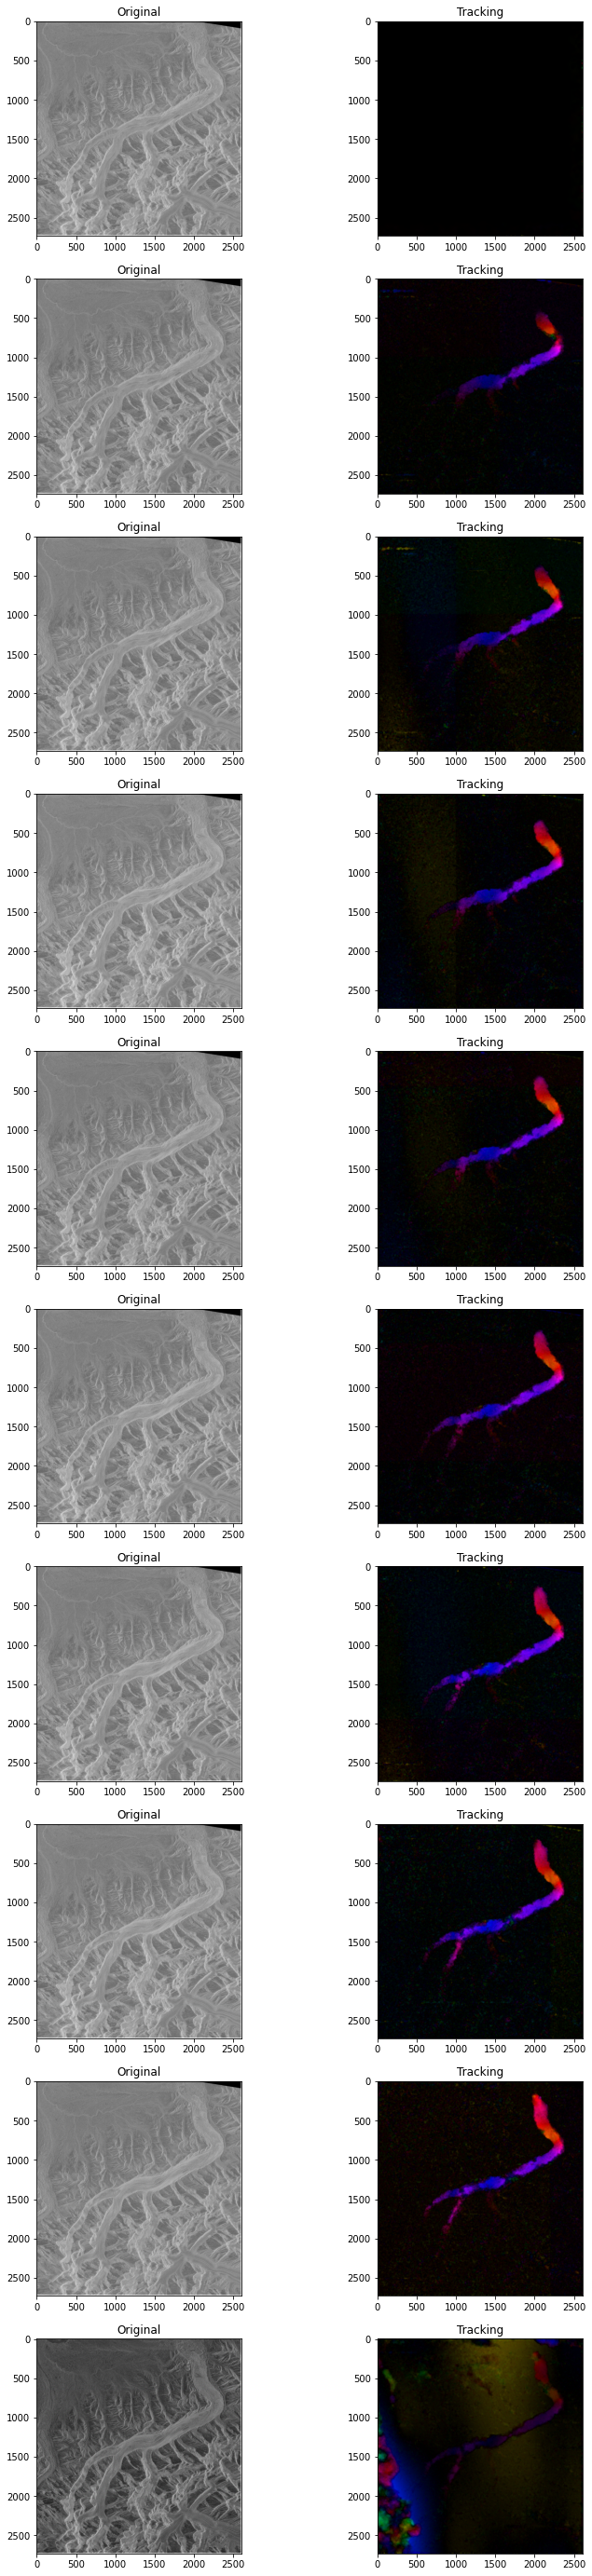

In [1]:
import glob
import cv2 as cv
import numpy as np
from tqdm import notebook
from matplotlib import pyplot as plt

first_frame = cv.imread('images/0image.png')
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
mask = np.zeros_like(first_frame)
mask[..., 1] = 255

f,ax=plt.subplots(len(glob.glob('images/*.png')),2,figsize=(12,50))
for i, filename in notebook.tqdm(enumerate(glob.glob('images/*.png'))):  
    frame = cv.imread(filename)
    
    ax[i,0].imshow(frame)
    ax[i,0].set_title('Original')
    
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prev_gray, gray, 
                                       None,
                                       0.5, 3, 15, 3, 5, 1.2, 0)
      
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])

    mask[..., 0] = angle * 180 / np.pi / 2
      
    mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
      
    rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
      
    ax[i,1].imshow(rgb)
    ax[i,1].set_title('Tracking')
      
    prev_gray = gray

# Motion Detection from Live Camera

In [2]:
import imutils
import cv2
import numpy as np

# =============================================================================
# USER-SET PARAMETERS
# =============================================================================

# Number of frames to pass before changing the frame to compare the current
# frame against
FRAMES_TO_PERSIST = 10

# Minimum boxed area for a detected motion to count as actual motion
# Use to filter out noise or small objects
MIN_SIZE_FOR_MOVEMENT = 2000

# Minimum length of time where no motion is detected it should take
#(in program cycles) for the program to declare that there is no movement
MOVEMENT_DETECTED_PERSISTENCE = 100

# =============================================================================
# CORE PROGRAM
# =============================================================================


# Create capture object
cap = cv2.VideoCapture(5) # Flush the stream
cap.release()
cap = cv2.VideoCapture(0) # Then start the webcam

# Init frame variables
first_frame = None
next_frame = None

# Init display font and timeout counters
font = cv2.FONT_HERSHEY_SIMPLEX
delay_counter = 0
movement_persistent_counter = 0

# LOOP!
while True:

    # Set transient motion detected as false
    transient_movement_flag = False
    
    # Read frame
    ret, frame = cap.read()
    text = "Unoccupied"

    # If there's an error in capturing
    if not ret:
        print("CAPTURE ERROR")
        continue

    # Resize and save a greyscale version of the image
    frame = imutils.resize(frame, width = 750)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Blur it to remove camera noise (reducing false positives)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)

    # If the first frame is nothing, initialise it
    if first_frame is None: first_frame = gray    

    delay_counter += 1

    # Otherwise, set the first frame to compare as the previous frame
    # But only if the counter reaches the appriopriate value
    # The delay is to allow relatively slow motions to be counted as large
    # motions if they're spread out far enough
    if delay_counter > FRAMES_TO_PERSIST:
        delay_counter = 0
        first_frame = next_frame

        
    # Set the next frame to compare (the current frame)
    next_frame = gray

    # Compare the two frames, find the difference
    frame_delta = cv2.absdiff(first_frame, next_frame)
    thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)[1]

    # Fill in holes via dilate(), and find contours of the thesholds
    thresh = cv2.dilate(thresh, None, iterations = 2)
    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # loop over the contours
    for c in cnts:

        # Save the coordinates of all found contours
        (x, y, w, h) = cv2.boundingRect(c)
        
        # If the contour is too small, ignore it, otherwise, there's transient
        # movement
        if cv2.contourArea(c) > MIN_SIZE_FOR_MOVEMENT:
            transient_movement_flag = True
            
            # Draw a rectangle around big enough movements
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # The moment something moves momentarily, reset the persistent
    # movement timer.
    if transient_movement_flag == True:
        movement_persistent_flag = True
        movement_persistent_counter = MOVEMENT_DETECTED_PERSISTENCE

    # As long as there was a recent transient movement, say a movement
    # was detected    
    if movement_persistent_counter > 0:
        text = "Movement Detected " + str(movement_persistent_counter)
        movement_persistent_counter -= 1
    else:
        text = "No Movement Detected"

    # Print the text on the screen, and display the raw and processed video 
    # feeds
    cv2.putText(frame, str(text), (10,35), font, 0.75, (255,255,255), 2, cv2.LINE_AA)
    
    # For if you want to show the individual video frames
#    cv2.imshow("frame", frame)
#    cv2.imshow("delta", frame_delta)
    
    # Convert the frame_delta to color for splicing
    frame_delta = cv2.cvtColor(frame_delta, cv2.COLOR_GRAY2BGR)

    # Splice the two video frames together to make one long horizontal one
    cv2.imshow("frame", np.hstack((frame_delta, frame)))


    # Interrupt trigger by pressing q to quit the open CV program
    ch = cv2.waitKey(1)
    if ch & 0xFF == ord('q'):
        break

# Cleanup when closed
cv2.waitKey(0)
cv2.destroyAllWindows()
cap.release()

<center>
    <br>
    <br>
    <h5 style = "color:green">--------------------------------------------------------------------------------------------</h5>
    <h1 style = "color:blue">Thank you so much</h1>
    <h5 style = "color:green">--------------------------------------------------------------------------------------------</h5>
    <br>
    <br>
<center>